# Kmeans_EM.ipynb
By: Shawn Vosburg (260743167)  
Due: November 5th, 2018  
Course: ECSE415, McGill University (Montreal,QC)  

# 1. K-means clustering and Expectation Maximization (35 points)

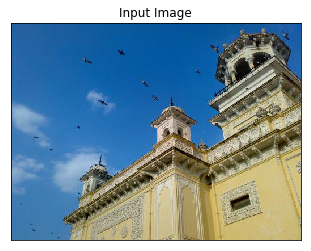

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('home.jpg');
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.show()

## 1.1 Implement K-means clustering algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images but not for clustering. Apply k-means to the provided image with K=2 and K=3. Display the resulting segmented images for 10 iterations in both cases.

In [3]:
#This is the function that will return the K-mean centers after N iterations.
def _myKmeans(data,K,N):
    """ data: vector that contains datapoint. Must be in form (x,y,ColorChannel) Must be NORMALIZED vectors. 
        K:    Number of Centeroids
        N:    Number of iterations
        Returns: Label of each points in the dataset found from the KMeans. 
    """
    #Reshape the data so that the pixels are all in one dimension. Kepp information about original image size
    originalShape = data.shape
    data = np.reshape(data,(data.shape[0] * data.shape[1], -1))
    #initialize centeroids
    centeroids = _initializeCenteroids(K,data); 
    
    #Variables for forloop control and state saving.
    oldCenteroids = []
    for i in range(N):       
        #Obtain labels for each pixels. Is a single value coressponding to the centeroid it is associated with. 
        labels = _getLabels(data,centeroids)
        #Calculate new centeroids.
        centeroids = _getCentroids(data,labels,centeroids, K)
            
    #Build output
    output = data.copy() #Get general shape of data
    for pixelNum in range(data.shape[0]):
        output[pixelNum] = centeroids[int(labels[pixelNum])]
    return np.reshape(output,(originalShape));

#returns position of centeroids. K is the number of total centeroids. Value of channels is [0,1]. 
def _initializeCenteroids(K,data):
    """
    K: Number of centeroids
    data: data array
    Returns: position of Centeroids (random)
    """
    centeroids = []
    for i in range(K):
        centeroids.append(data[np.random.randint(0,data.shape[0]-1)])
    return np.asarray(centeroids)

#Returns labels of the data. Matches data to the label of the closest centeroid. 
def _getLabels(data,centeroids):
    """
    data: 2-D array of point with postion.
    centeroids: K-centers with their position
    Returns: Array with 1st dimension being the pixels and the second dimension being the label value (int).
    """
    Labels = np.zeros((data.shape[0],1))
    for i in range(data.shape[0]):
        #initialize to first label. 
        minDist = _EuclideanDistance2(centeroids[0],data[i]) 
        minDistLabel = 0
        
        #iterate over all centeroids and find the smallest distance.
        for j in range(centeroids.shape[0]):
            dist = _EuclideanDistance2(centeroids[j],data[i])
            if( dist < minDist ):
                minDist = dist
                minDistLabel = j #set label
        #Assign Label value
        Labels[i] = minDistLabel
    return Labels

#Returns the new centeroids with the newly labeled data
def _getCentroids(data, labels,centers,K):
    """
    data: Array of datapoints
    labels: Array of labels of each datapoints
    K: Number of centeroids to produce
    centers: Old centeroids. 
    Returns: position of new centeroids.     
    """
    #Initiate counting arrays
    numPoints = np.zeros((K))
    centerPosition = np.zeros((K,data.shape[1]))
    
    #Iterate through all the data points and its labels and add them to appropriate bucket. 
    for pixelNum in range(data.shape[0]):
        numPoints[int(labels[pixelNum])] += 1 
        centerPosition[int(labels[pixelNum])] += data[pixelNum]
    
    #iterate through all centeroids and average out the centerPosition
    for i in range(K):
        if(numPoints[i] != 0):
            centerPosition[i] /= numPoints[i]
        else:
            centerPosition[i] = centers[i]
            
    return centerPosition

#Returns the square of the distance between vector v1,v2. The minimum distance will also produce the minimum distance squared.
def _EuclideanDistance2(v1,v2):
    """
    v1: Vector 1
    v2: Vector 2
    """
    total = 0
    for i in range(v1.shape[0]):
        total += (v1[i] - v2[i]) ** 2 
    return total

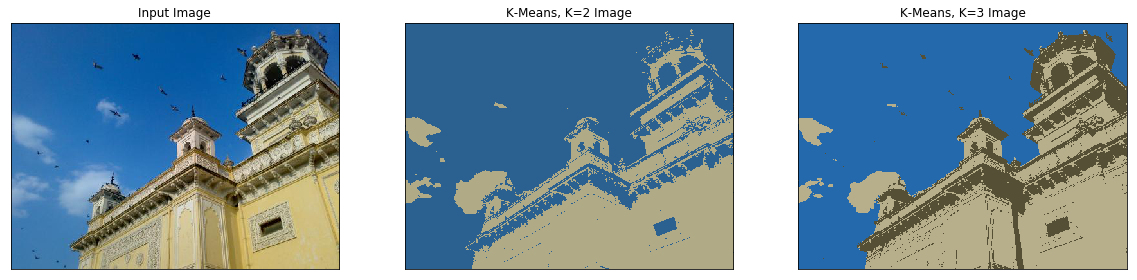

In [4]:
# Following pseudocode developped at following website: 
# http://stanford.edu/~cpiech/cs221/handouts/kmeans.html

#Create copy of img to keep from overwriting input.
imgK = img.copy()
imgK = imgK/255; #Convert to float in range [0,1]

K = 2; #Number of buckets
N = 10;#Number of iterations. 
imgK2 = _myKmeans(imgK,K,N);

K = 3; #Number of buckets
N = 10;#Number of iterations. 
imgK3 = _myKmeans(imgK,K,N);

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(imgK2)
plt.title("K-Means, K=2 Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(imgK3)
plt.title("K-Means, K=3 Image"), plt.xticks([]), plt.yticks([])
plt.show()

## 1.2 Implement the EM algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images. Apply it to the given image with 2 and 3 Gaussian components. Display the resulting segmented images for 10 iterations in both cases.

In [5]:
#This is the function that will return the gaussian 
def _myEMmeans(data,K,N):
    """ data: vector that contains datapoint. Must be in form (x,y,ColorChannel) Must be NORMALIZED vectors. 
        K:    Number of Centeroids
        N:    Number of iterations
        Returns: Label of each points in the dataset found from the EM algorithm. 
    """
    #Reshape the data so that the pixels are all in one dimension. Kepp information about original image size
    originalShape = data.shape
    data = np.reshape(data,(data.shape[0] * data.shape[1], -1))
    
    #intialize variables
    mean, covariance, weight = _initializeGaussians(K,data)
    
    #Variables for forloop control and state saving.
    for i in range(N):
        #E step
        labels = _getLabelsEM(data,mean,covariance,weight)
        #M step
        mean,covariance, weight = _getGaussians(data,labels,mean, K)
            
    #Build output
    output = data.copy() #Get general shape of data
    for pixelNum in range(data.shape[0]):
        maxGaussianNum = 0
        maxProb = 0
        #Find which gaussian the pixel is most likely to be
        for gaussianNum in range(K):
            if(labels[pixelNum][gaussianNum] > maxProb):
                maxProb = labels[pixelNum][gaussianNum]
                maxGaussianNum = gaussianNum
        output[pixelNum] = mean[maxGaussianNum]
    return np.reshape(output,(originalShape))


#Initializes randomly the gaussians
def _initializeGaussians(K,data):
    """
    K: Number of Gaussians
    data: Datapoints array
    Returns: param of Gaussians (random)
    """
    mean = np.zeros((K,3))
    covariance = np.zeros((K,3,3))
    weight = np.zeros((K))
    
    #initialize
    for i in range(K):
        mean[i] = data[np.random.randint(0,data.shape[0]-1)]
    covariance[:] = np.eye(3)
    weight[:] = 1/K

    
    return mean,covariance,weight

#Finds the labels according to Gaussian parameters
def _getLabelsEM(data,mean,covariance,weight):
    """
    data: 2-D array of point with postion.
    mean,covariance: parameter of gaussians
    Returns: Array with NxK dimensions with the probabilities of a pixel being part of a particular gaussian.
    """
    Labels = np.zeros((data.shape[0],mean.shape[0]))
    diff = np.zeros(data.shape[0])
    #Find each probabilities.
    for i in range(data.shape[0]):
        for j in range(mean.shape[0]):
            diff = data[i] - mean[j]
            label = weight[j] * (1/np.sqrt(2*np.pi)/np.sqrt(np.linalg.det(covariance[j])))
            label *= np.exp(-0.5*np.dot(np.dot(diff,np.linalg.inv(covariance[j])),np.transpose(diff)))
            Labels[i][j] = label
        #Normalize propabilibities
        Labels[i] = Labels[i]/sum(Labels[i])
    
    return Labels

#Finds new parameters of the gaussians
def _getGaussians(data,labels,mean, K):
    """
    data: Array of datapoints
    labels: Array of labels of each datapoints
    K: Number of centeroids to produce 
    mean: Old Gaussian mean values
    Returns: parameters of new gaussians.     
    """
    #Initiate counting arrays
    sumProbs = np.zeros((K))
    newMean = np.zeros((K,3))
    numLabels = np.zeros(K)
    newCov = np.zeros((K,3,3))
    newWeight = np.zeros(K)
    
    #First, calculate the sum of the probabilities for each pixels.
    for gaussianNum in range(K):
        for pixelNum in range(data.shape[0]):
            sumProbs[gaussianNum] += labels[pixelNum][gaussianNum]
            
    #New mean
    for gaussianNum in range(K):
        for pixelNum in range(data.shape[0]):
            newMean[gaussianNum] += data[pixelNum] * labels[pixelNum][gaussianNum]
        newMean[gaussianNum] /= sumProbs[gaussianNum]
    
    #New Standard Dev
    for gaussianNum in range(K):
        for pixelNum in range(data.shape[0]):
            diff =(data[pixelNum] - mean[gaussianNum])[np.newaxis]
            newCov[gaussianNum] += labels[pixelNum][gaussianNum] * np.dot(np.transpose(diff), diff)
        newCov[gaussianNum] /= sumProbs[gaussianNum]   
            
    #New weight
    for gaussianNum in range(K):
        newWeight[gaussianNum] = sumProbs[gaussianNum] / data.shape[0]
        
    return newMean, newCov, newWeight
    
def _findBestLabel(K,labels):
    """
    K: Number of gaussians
    labels: Probability of each gaussian. 
    """
    maxGaussianNum = 0
    maxProb = 0
    #Find which gaussian the pixel is most likely to be
    for gaussianNum in range(K):
        if(labels[gaussianNum] > maxProb):
            maxProb = labels[gaussianNum]
            maxGaussianNum = gaussianNum
    return maxGaussianNum

#Returns the square of the distance between vector v1,v2. The minimum distance will also produce the minimum distance squared.
def _EuclideanDistance2(v1,v2):
    """
    v1: Vector 1
    v2: Vector 2
    """
    total = 0
    for i in range(v1.shape[0]):
        total += (v1[i] - v2[i]) ** 2 
    return total

def _imPrint(labels, data , mean,originalShape):
    """
    labels: Probabilities of gaussians
    data: linear array of pixels
    mean: Centers of gaussians
    OriginalShape: Shape of original image.
    """
    #Build output
    output = data.copy() #Get general shape of data
    for pixelNum in range(data.shape[0]):
        maxGaussianNum = 0
        maxProb = 0
        #Find which gaussian the pixel is most likely to be
        for gaussianNum in range(K):
            if(labels[pixelNum][gaussianNum] > maxProb):
                maxProb = labels[pixelNum][gaussianNum]
                maxGaussianNum = gaussianNum
        output[pixelNum] = mean[maxGaussianNum]
    plt.imshow( np.reshape(output,(originalShape)))
    plt.title("Input Image"), plt.xticks([]), plt.yticks([])
    plt.show()
    



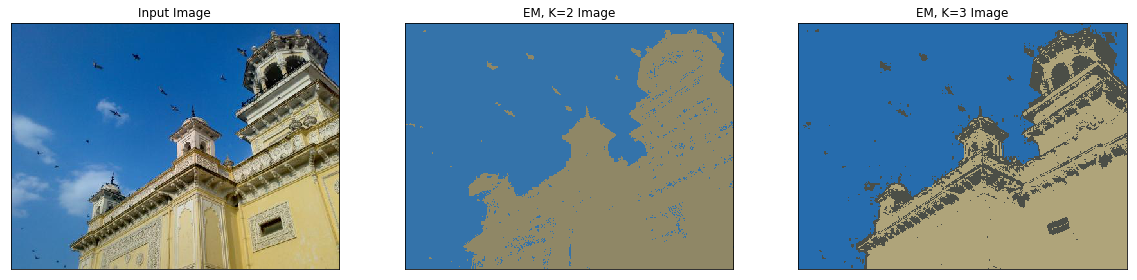

In [6]:
#Took pseudcode from class notes. 

#Create copy of img to keep from overwriting input.
imgEM = img.copy()
imgEM = imgEM/255; #Convert to float in range [0,1]

K = 2; #Number of gaussian
N = 10;#Number of iterations. 
imgEM2 = _myEMmeans(imgEM,K,N);

K = 3; #Number of gaussian
N = 10;#Number of iterations. 
imgEM3 = _myEMmeans(imgEM,K,N);

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(imgEM2)
plt.title("EM, K=2 Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(imgEM3)
plt.title("EM, K=3 Image"), plt.xticks([]), plt.yticks([])
plt.show()

## 1.3 Under what data distribution conditions would K-means and EM give the same solution, provided similar initializations?

**ANSWER:**  
When the clusters in the data distribution are spherically position in their respective domain, the K-Means and EM algorithms will provide the same result. Having spherical clusters will generate identical covariance matricies for each cluster for EM. The label of a data point would therefore rely only on its distance from the means of the clusters as they all have the same covariance. A data point being closer to a given cluster A compared to cluster B, if both gaussians have the same covariance, will label the datapoint as being part of cluster A. Only the distance from the mean determines the label of the datapoint, just like for K-means. In this scenario, the K-center is analogous to the mean of the gaussian distribution. 